## About

This page showcases the work of [Georgios Karamanis](https://www.karaman.is), 
built for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) 
initiative. You can find the original code on his github repository 
[here](https://github.com/gkaramanis/tidytuesday/blob/master/2021/2021-week34/lemurs.R), written in [R](https://www.r-graph-gallery.com).

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tcapretto.netlify.app) who translated this work from R to Python! 🙏🙏


As a teaser, here is the plot we’re gonna try building:

![preview final chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-lemurs-parallel-chart.png?raw=true)

## Load libraries

Let's get started by loading the libraries and utilities that are going to be used today.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D

## Load the dataset

The data for this post originally comes from the [Duke Lemur Center](https://lemur.duke.edu/) and was cleaned by [Jesse Mostipak](https://github.com/rfordatascience/tidytuesday/issues/204). This guide uses the dataset released for the [TidyTuesday](https://github.com/rfordatascience/tidytuesday) initiative on the week of 2021-08-24. You can find the original announcement and more information about the data [here](https://github.com/rfordatascience/tidytuesday/blob/master/data/2021/2021-08-24/readme.md). Thank you all for making this work possible! 🙏🙏

Two datasets are needed today. The first one, called `lemurs`, has information about the lemurs themselves, while `taxonomy` is going to be helpful to obtain the latin names of the species.

In [2]:
lemurs = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-08-24/lemur_data.csv",
    engine = "python",
    encoding = "ISO-8859-1"
)

taxonomy = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-08-24/taxonomy.csv"
)

Now let's compute the maximum age recorded and the number of animals by species and sex:

In [3]:
data = (
    lemurs
    # Keep unique combinations of the following variables.
    .drop_duplicates(["dlc_id", "taxon", "sex", "age_max_live_or_dead_y"])
    # Drop observations with Not Determined sex
    .query("sex != 'ND'")
    # Compute highest age and the number of lemurs for each specie and sex
    .groupby(["taxon", "sex"])
    .agg(
        age_max=pd.NamedAgg("age_max_live_or_dead_y", max),
        count=pd.NamedAgg("age_max_live_or_dead_y", "size")
    )
    .reset_index()
)

In [4]:
# Pivot the data so we have two columns for each 'age_max' and 'count',
# one if for Females and the other is for Males
data = pd.pivot_table(
    data, index="taxon", columns="sex", values=["age_max", "count"]
).reset_index()

# The above produces MultiIndex column names
# Join them
data.columns = data.columns.map("_".join).str.strip("_")

# Clean one of the taxon names that is misspelled
data["taxon"] = np.where(data["taxon"] == "CMED", "CMEAD", data["taxon"])

# Merge aggregated data with the taxonomy to obtain species names
data = pd.merge(data, taxonomy, how="left", on="taxon")

In [5]:
data.head()

,taxon,age_max_F,age_max_M,count_F,count_M,latin_name,common_name
0,CMEAD,25.18,29.62,82,97,Cheirogaleus medius,Fat-tailed dwarf lemur
1,DMAD,35.20,32.64,22,15,Daubentonia madagascariensis,Aye-aye
2,EALB,34.59,27.75,5,12,Eulemur albifrons,White-fronted brown lemur
3,ECOL,32.61,32.35,24,32,Eulemur collaris,Collared brown lemur
4,ECOR,27.42,28.82,23,34,Eulemur coronatus,Crowned lemur


And that's it for the manipulation of the original data frames. The next steps are about getting the values in a convenient way for the plotting with Matplotlib.

One of the first things, is to define the colors we're gonna use:

In [6]:
# Numbers between 0 and 1 indicate different shades of grey
GREY96 = "0.96"
GREY30 = "0.3"
GREY15 = "0.15"

BLUE = "#3A8AD8"
ORANGE = "#F2A039"

Next, we create the objects that store the names of the species, the values for the maximum age by sex, and the colors that are applied.

In [7]:
names = data["latin_name"].values
age_max_F = data["age_max_F"].values
age_max_M = data["age_max_M"].values
color =  np.where(data["age_max_F"] > data["age_max_M"], BLUE, ORANGE)

The size of the dots is given by the number of lemurs hosted at the Duke Lemur Center (DLC). Here there is a function that is going to be used to scale the number of lemurs.

In [8]:
def scale(x, x_min=None, x_max=None, lower=0, upper=1):
    if x_min is None:
        x_min = np.min(x)
    if x_max is None:
        x_max = np.max(x)
    return (x - x_min) / (x_max - x_min) * (upper - lower) + lower

And now get the size values. Not the minimum and the maximum number of lemurs are obtained considering both sexes.

In [9]:
n_lemurs_min = min(np.min(data["count_F"]), np.min(data["count_M"]))
n_lemurs_max = max(np.max(data["count_F"]), np.max(data["count_M"]))

lower = 10
upper = 100

size_F = scale(data["count_F"].values, n_lemurs_min, n_lemurs_max, lower, upper)
size_M = scale(data["count_M"].values, n_lemurs_min, n_lemurs_max, lower, upper)

And last but not least, there's the following dictionary. It contains the vertical adjustments that are applied to the labels of the species. In the original work, these adjustments are obtained automatically with the [`ggrepel`](https://ggrepel.slowkow.com/index.html) library in [R](https://www.r-graph-gallery.com). Python has its own alternative, [`adjustText`](https://github.com/Phlya/adjustText), which unfortunately didn't work well for this case.

In [10]:
vertical_adjustments = {
    "Varecia rubra": 0,
    "Daubentonia madagascariensis": 0.6,
    "Eulemur macaco": 0.6,
    "Eulemur rubriventer": 0.4,
    "Eulemur sanfordi": 0.5,
    "Eulemur collaris": -0.1,
    "Perodicticus potto": -0.6,
    "Lemur catta": 0,
    "Eulemur flavifrons": 0,
    "Nycticebus coucang": 0,
    "Otolemur garnettii garnettii": 0,
    "Mircocebus murinus": 0,
    "Galago moholi": 0,
    "Varecia variegata variegata": 0,
    "Eulemur mongoz": 0,
    "Eulemur fulvus": 0,
    "Eulemur rufus": 0,
    "Propithecus coquereli": 0.3,
    "Cheirogaleus medius": 0.3,
    "Eulemur Eulemur": -0.1,
    "Eulemur coronatus": -0.35,
    "Eulemur albifrons": -0.25,
    "Hapalemur griseus griseus": 0,
    "Loris tardigradus": 0,
    "Mirza coquereli": 0,
    "Varecia Varecia": 0,
    "Nycticebus pygmaeus": 0
}

It's been quite enough for an introduction. Let's get started with the plot! 

## Basic parallel plot

This parallel plot is made of two components: lines and dots. It's important to note that these lines are added
one at a time because they are not connected.

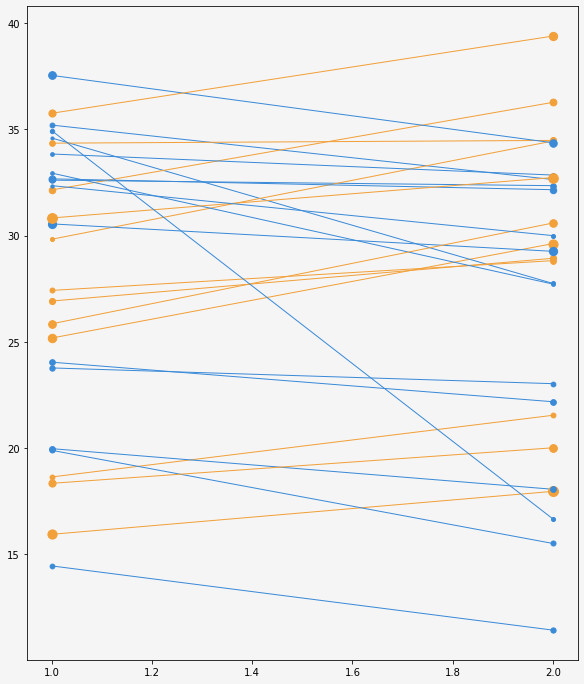

In [11]:
# Initialize plot
fig, ax = plt.subplots(figsize = (9, 11))

# Adjust figure margins, this is going to be useful later.
fig.subplots_adjust(left=0.05, right=0.90, top=0.9, bottom=0.075)

# Set background color
fig.set_facecolor(GREY96)
ax.set_facecolor(GREY96)

# Iterate over ages, colors, and sizes, adding one line and pair of dots at a time
# Note the horizontal positions are fixed at 1 and 2.
for y0, y1, c, s0, s1 in zip(age_max_F, age_max_M, color, size_F, size_M):
    ax.plot([1, 2], [y0, y1], c=c, lw=1)
    ax.scatter(1, y0, c = c, s=s0, zorder=10)
    ax.scatter(2, y1, c = c, s=s1, zorder=10)

## Add labels

That was a pretty good start. Now it's a good time to add the labels for the species. 

This is when the chart gets really insightful because the labels allow us to identify each species and compare them.

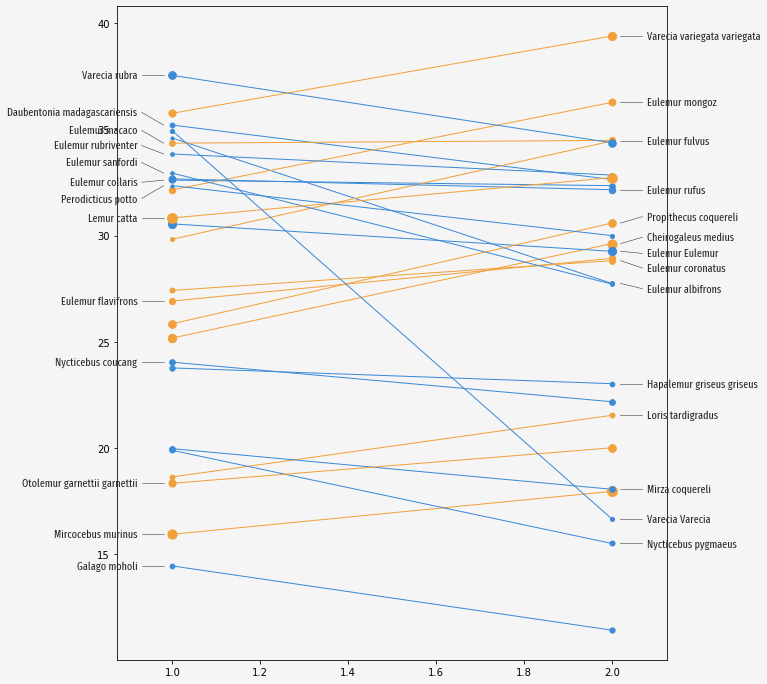

In [12]:
# Space between the dot and the label
TEXT_HPADDING = 0.08

# Space between the line and the dot
LINE_HPADDING1 = 0.02
# Space between the line and the label
LINE_HPADDING2 = 0.07

for i, name in enumerate(names):
    # Take the vertical adjustment for the name
    VA = vertical_adjustments[name]
    
    # If it is odd, plot on the left
    if i % 2 != 0:
        # Add label
        x = 1 - TEXT_HPADDING
        y = age_max_F[i] + VA
        ax.text(
            x, y, name, size=11, name="Fira Sans Compressed", 
            color=GREY15, ha="right", va="center" 
        )
        
        # Add line connect dot with label
        x = [1 - LINE_HPADDING2, 1 - LINE_HPADDING1]
        y = [age_max_F[i] + VA, age_max_F[i]]
        ax.plot(x, y, color=GREY15, lw=0.5)
        
    # If it is even, plot on the right
    else:
        # Add label
        x = 2 + TEXT_HPADDING
        y = age_max_M[i] + VA
        ax.text(
            x, y, name, size=11, name="Fira Sans Compressed", 
            color=GREY15, va="center" 
        )
        # Add line connect dot with label
        x = [2 + LINE_HPADDING1, 2 + LINE_HPADDING2]
        y = [age_max_M[i], age_max_M[i] + VA]
        ax.plot(x, y, color=GREY15, lw=0.5)
fig

## Clean and customize layout

The first thing that's needed here is to remove the frame and the axis ticks. They're so bothering!

Next, we're going to add horizontal lines in the background, together with annotations indicating the ages, and other annotations telling which side represents which sex.

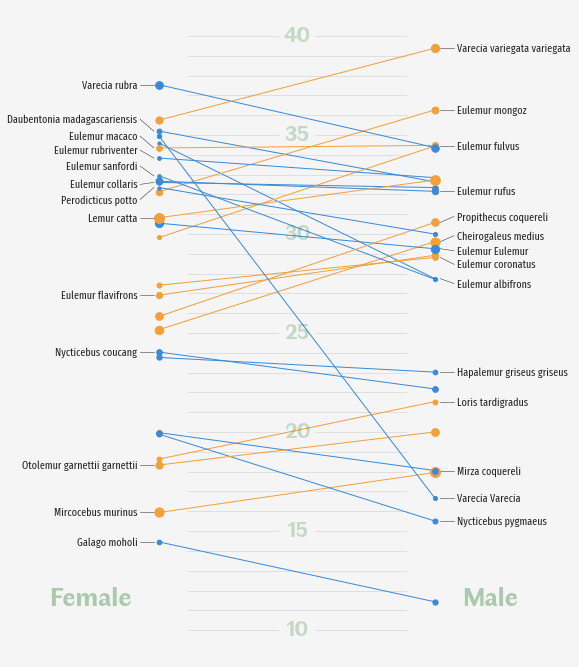

In [13]:
# Remove all spines
ax.set_frame_on(False)

# Remove horizontal and vertical ticks
ax.set_xticks([])
ax.set_yticks([])

# Expand horizontal limits to (0.5, 2.5)
ax.set_xlim(0.5, 2.5)

# Horizontal lines in the background
ax.hlines(np.arange(10, 41), 1.1, 1.9, alpha=0.2, lw=0.5, color=GREY15, zorder=0)

# Add annotations
# Note the dots added with ax.scatter are the text backgrounds
for y in np.arange(10, 45, 5):
    ax.scatter(1.5, y, s=1200, color=GREY96)
    ax.text(
        1.5, y, str(y), 
        size=22, name="Faune", color="darkgreen", weight="bold",
        alpha=0.2, va="center", ha="center"
    )


ax.text(
    0.9, 11.25, "Female", 
    name="Faune", size=27, color="darkgreen", 
    weight="bold", alpha=0.3, ha="right"
)

ax.text(
    2.1, 11.25, "Male", name="Faune", size=27, color="darkgreen", 
    weight="bold", alpha=0.3,ha="left"
)    
    
fig

Yay! It's really looking better and cleaner now!

## Add legend

One of the last steps is to add the legend. This legend is going to tell us what is being represented by the dot sizes. Note the legend is made entirely from scratch. Want to see it? Let's do it!

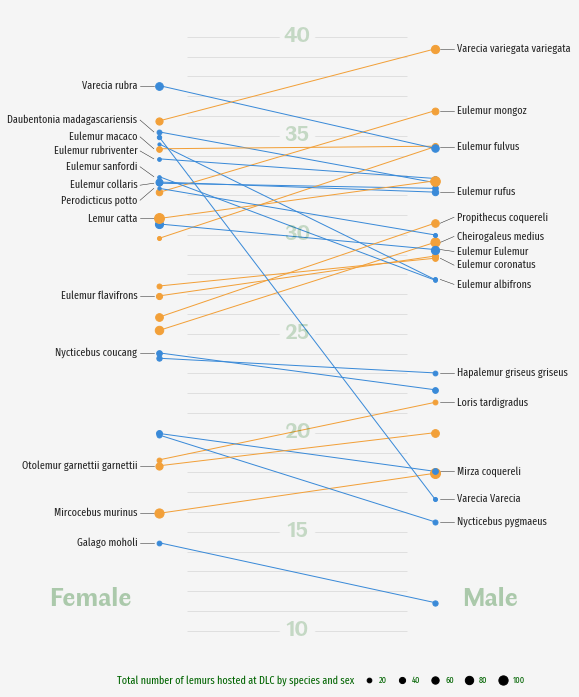

In [14]:
# Create the values represented in the legend
labels = np.array([20, 40, 60, 80, 100])

# Scale the values to the actual dot size
sizes = scale(labels, n_lemurs_min, n_lemurs_max, lower, upper)

# Create handles
# Note the first handle is just a label, which plays the role of a title
handles = [Line2D([], [], label="Total number of lemurs hosted at DLC by species and sex", lw=0)]

# And the other handles are the dots
# See `markersize=np.sqrt(size)`. 
# This is because `s` in `ax.scatter` is measured in squared units.
handles += [
    Line2D(
        [], 
        [], 
        label=str(label), 
        lw=0, 
        color="None",
        marker="o",
        markersize=np.sqrt(size),
        markerfacecolor="black"
    )
    for label, size in zip(labels, sizes)
]

# Add legend to the figure
# bbox_to_anchor and loc="center" mean it is located in the bottom center
legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, 0.05],
    handletextpad=0.5,
    handlelength=1, 
    columnspacing=1,
    loc="center", 
    ncol=6,
    frameon=False
)

# Customize style of the fonts in the legends
# The first text, which is the title, has a larger text size
for i, text in enumerate(legend.get_texts()):
    text.set_fontfamily("Fira Sans Compressed")
    text.set_color("darkgreen")
    if i == 0:
        text.set_fontsize(11)
    else:
        text.set_fontsize(9)

fig

## Add title and extra annotations

The chart above is just one step away from being publication-ready. This final touch consists of adding a good title and a subtitle to clearly describe what you see in the chart, and a caption giving appropriate credit to the author of the visualization and the people who made the data available. 

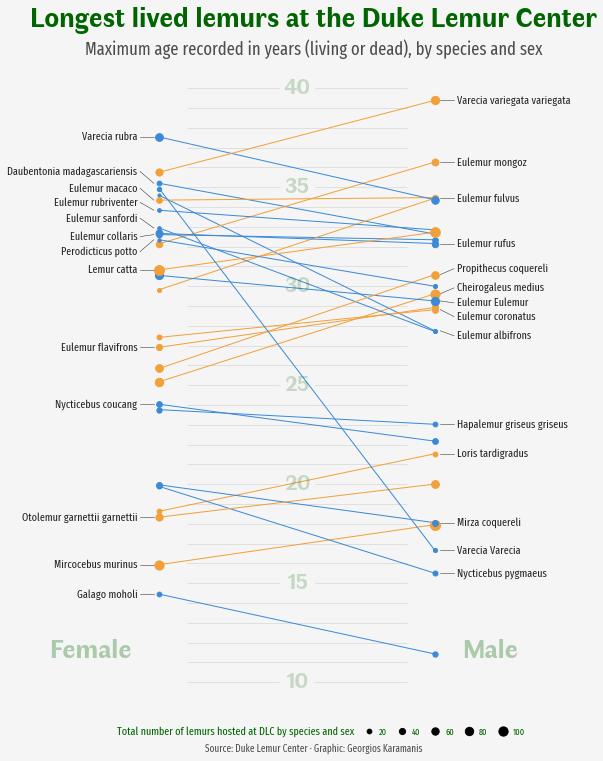

In [15]:
# Note all these annotations are centered horizontally

# Title
fig.text(
    0.5, 0.94, "Longest lived lemurs at the Duke Lemur Center",
    size=28,
    name="Faune",
    weight="bold",
    ha="center",
    color="darkgreen",
)

# Sub-title
fig.text(
    0.5, 0.905, "Maximum age recorded in years (living or dead), by species and sex",
    size=18,
    name="Fira Sans Compressed",
    color=GREY30,
    ha="center",
)

# Caption
fig.text(
    0.5, 0.025, "Source: Duke Lemur Center · Graphic: Georgios Karamanis",
    size=10, 
    color=GREY30, 
    family="Fira Sans Compressed", 
    ha="center"
)


fig
# fig.savefig("plot.png", dpi=320) to store it as PNG

It's been so exciting to work on this chart! 🤩